In [79]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

# Data path: use project data/ folder (works when run from experiments/ or project root)
DATA_DIR = os.path.abspath("../data") if os.path.isdir("../data") else os.path.abspath("data")
for dirname, _, filenames in os.walk(DATA_DIR):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/Users/jacobkuriakose/Desktop/Walmart/Data-Driven-Walmart-Sales-Predictions/data/sales_train_evaluation.csv
/Users/jacobkuriakose/Desktop/Walmart/Data-Driven-Walmart-Sales-Predictions/data/.DS_Store
/Users/jacobkuriakose/Desktop/Walmart/Data-Driven-Walmart-Sales-Predictions/data/calendar.csv
/Users/jacobkuriakose/Desktop/Walmart/Data-Driven-Walmart-Sales-Predictions/data/sell_prices.csv
/Users/jacobkuriakose/Desktop/Walmart/Data-Driven-Walmart-Sales-Predictions/data/sales_train_validation.csv
/Users/jacobkuriakose/Desktop/Walmart/Data-Driven-Walmart-Sales-Predictions/data/sample_submission.csv


In [80]:
# MLflow: log to project mlflow.db so plain "mlflow ui" (from project root) shows these runs
import mlflow
import pickle
import tempfile
import os
from pathlib import Path
_root = Path.cwd() if (Path.cwd() / "src").exists() else Path.cwd().parent
mlflow.set_tracking_uri(f"sqlite:///{(_root / 'mlflow.db').resolve().as_posix()}")
mlflow.set_experiment("experiments-arima-exponential-smoothing")

2026/02/28 13:45:32 INFO mlflow.tracking.fluent: Experiment with name 'experiments-arima-exponential-smoothing' does not exist. Creating a new experiment.


<Experiment: artifact_location='/Users/jacobkuriakose/Desktop/Walmart/Data-Driven-Walmart-Sales-Predictions/Notebooks/mlruns/1', creation_time=1772311532793, experiment_id='1', last_update_time=1772311532793, lifecycle_stage='active', name='experiments-arima-exponential-smoothing', tags={}, workspace='default'>

In [81]:
sell_prices = pd.read_csv(os.path.join(DATA_DIR, "sell_prices.csv"))
sample_submission = pd.read_csv(os.path.join(DATA_DIR, "sample_submission.csv"))
calendar = pd.read_csv(os.path.join(DATA_DIR, "calendar.csv"))
sales_train_validation = pd.read_csv(os.path.join(DATA_DIR, "sales_train_validation.csv"))
sales_train_evaluation = pd.read_csv(os.path.join(DATA_DIR, "sales_train_evaluation.csv"))

In [82]:
sell_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [83]:
sell_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   store_id    object 
 1   item_id     object 
 2   wm_yr_wk    int64  
 3   sell_price  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [84]:
sales_train_validation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [85]:
sales_train_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


In [86]:
sales_train_validation['store_id'].unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

In [87]:
sales_train_evaluation.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [88]:
sales_train_evaluation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1947 entries, id to d_1941
dtypes: int64(1941), object(6)
memory usage: 452.9+ MB


##Pre-processing and Exploration of the data.

In [89]:
numerical_columns = sales_train_validation.select_dtypes(include=['number'])
numerical_columns.groupby(sales_train_validation['store_id']).sum()

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
store_id,,,,,,,,,,,,,,,,,,,,,
CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,...,3982,5437,5954,4345,3793,3722,3709,4387,5577,6113
CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,2218,...,4440,5352,5760,3830,3631,3691,3303,4457,5884,6082
CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,4912,...,5337,6936,8271,6068,5683,5235,5018,5623,7419,7721
CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,1535,...,2496,2839,3047,2809,2677,2500,2458,2628,2954,3271
TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,2174,...,3084,3724,4192,3410,3257,2901,2776,3022,3700,4033
TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,2932,...,3897,4475,4998,3311,3727,3384,3446,3902,4483,4292
TX_3,3030,3006,2225,2169,1726,2833,1947,2848,2832,2213,...,3819,4261,4519,3147,3938,3315,3380,3691,4083,3957
WI_1,2704,2194,1562,1251,2,2049,2815,3248,1674,1355,...,3862,4862,4812,3236,3069,3242,3324,3991,4772,4874
WI_2,2256,1922,2018,2522,1175,2244,2232,2643,2140,1836,...,6259,5579,5566,4347,4464,4194,4393,4988,5404,5127


In [90]:
#Aggregate by the store level for now
numerical_columns = sales_train_validation.select_dtypes(include=['number'])
store_level = numerical_columns.groupby(sales_train_validation['store_id']).sum()
store_level['d'] = store_level.index
store_levelt = store_level.transpose()
store_levelt['d'] = store_levelt.index
store_levelt

store_id,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,d
d_1,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038,d_1
d_2,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198,d_2
d_3,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317,d_3
d_4,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211,d_4
d_5,2630,1942,3817,1536,1694,2492,1726,2,1175,2132,d_5
...,...,...,...,...,...,...,...,...,...,...,...
d_1910,3709,3303,5018,2458,2776,3446,3380,3324,4393,3226,d_1910
d_1911,4387,4457,5623,2628,3022,3902,3691,3991,4988,3828,d_1911
d_1912,5577,5884,7419,2954,3700,4483,4083,4772,5404,4686,d_1912
d_1913,6113,6082,7721,3271,4033,4292,3957,4874,5127,4325,d_1913


In [91]:
store_level

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d
store_id,,,,,,,,,,,,,,,,,,,,,
CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,...,5437,5954,4345,3793,3722,3709,4387,5577,6113,CA_1
CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,2218,...,5352,5760,3830,3631,3691,3303,4457,5884,6082,CA_2
CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,4912,...,6936,8271,6068,5683,5235,5018,5623,7419,7721,CA_3
CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,1535,...,2839,3047,2809,2677,2500,2458,2628,2954,3271,CA_4
TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,2174,...,3724,4192,3410,3257,2901,2776,3022,3700,4033,TX_1
TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,2932,...,4475,4998,3311,3727,3384,3446,3902,4483,4292,TX_2
TX_3,3030,3006,2225,2169,1726,2833,1947,2848,2832,2213,...,4261,4519,3147,3938,3315,3380,3691,4083,3957,TX_3
WI_1,2704,2194,1562,1251,2,2049,2815,3248,1674,1355,...,4862,4812,3236,3069,3242,3324,3991,4772,4874,WI_1
WI_2,2256,1922,2018,2522,1175,2244,2232,2643,2140,1836,...,5579,5566,4347,4464,4194,4393,4988,5404,5127,WI_2


In [92]:
calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          1969 non-null   object
 1   wm_yr_wk      1969 non-null   int64 
 2   weekday       1969 non-null   object
 3   wday          1969 non-null   int64 
 4   month         1969 non-null   int64 
 5   year          1969 non-null   int64 
 6   d             1969 non-null   object
 7   event_name_1  162 non-null    object
 8   event_type_1  162 non-null    object
 9   event_name_2  5 non-null      object
 10  event_type_2  5 non-null      object
 11  snap_CA       1969 non-null   int64 
 12  snap_TX       1969 non-null   int64 
 13  snap_WI       1969 non-null   int64 
dtypes: int64(7), object(7)
memory usage: 215.5+ KB


In [93]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [94]:
store_levelt.merge(calendar, on='d')

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198,...,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317,...,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211,...,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,2630,1942,3817,1536,1694,2492,1726,2,1175,2132,...,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,3722,3691,5235,2500,2901,3384,3315,3242,4194,3159,...,5,4,2016,NaN,NaN,NaN,NaN,0,0,0
1909,3709,3303,5018,2458,2776,3446,3380,3324,4393,3226,...,6,4,2016,NaN,NaN,NaN,NaN,0,0,0
1910,4387,4457,5623,2628,3022,3902,3691,3991,4988,3828,...,7,4,2016,NaN,NaN,NaN,NaN,0,0,0
1911,5577,5884,7419,2954,3700,4483,4083,4772,5404,4686,...,1,4,2016,NaN,NaN,NaN,NaN,0,0,0


In [95]:
#Merge this with the calendar data set to look at trends
store_level_final = store_levelt.merge(calendar, on='d')
from datetime import datetime
store_level_final['date'] = store_level_final['date'].apply(lambda t: datetime.strptime(t, '%Y-%m-%d'))
store_level_final

,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3,...,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038,...,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198,...,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317,...,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211,...,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,2630,1942,3817,1536,1694,2492,1726,2,1175,2132,...,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,3722,3691,5235,2500,2901,3384,3315,3242,4194,3159,...,5,4,2016,NaN,NaN,NaN,NaN,0,0,0
1909,3709,3303,5018,2458,2776,3446,3380,3324,4393,3226,...,6,4,2016,NaN,NaN,NaN,NaN,0,0,0
1910,4387,4457,5623,2628,3022,3902,3691,3991,4988,3828,...,7,4,2016,NaN,NaN,NaN,NaN,0,0,0
1911,5577,5884,7419,2954,3700,4483,4083,4772,5404,4686,...,1,4,2016,NaN,NaN,NaN,NaN,0,0,0


In [96]:
store_level_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1913 entries, 0 to 1912
Data columns (total 24 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   CA_1          1913 non-null   object        
 1   CA_2          1913 non-null   object        
 2   CA_3          1913 non-null   object        
 3   CA_4          1913 non-null   object        
 4   TX_1          1913 non-null   object        
 5   TX_2          1913 non-null   object        
 6   TX_3          1913 non-null   object        
 7   WI_1          1913 non-null   object        
 8   WI_2          1913 non-null   object        
 9   WI_3          1913 non-null   object        
 10  d             1913 non-null   object        
 11  date          1913 non-null   datetime64[ns]
 12  wm_yr_wk      1913 non-null   int64         
 13  weekday       1913 non-null   object        
 14  wday          1913 non-null   int64         
 15  month         1913 non-null   int64   

(array([15006., 15013., 15020., 15027., 15034., 15041., 15048.]),
 [Text(15006.0, 0, '2011-02-01'),
  Text(15013.0, 0, '2011-02-08'),
  Text(15020.0, 0, '2011-02-15'),
  Text(15027.0, 0, '2011-02-22'),
  Text(15034.0, 0, '2011-03-01'),
  Text(15041.0, 0, '2011-03-08'),
  Text(15048.0, 0, '2011-03-15')])

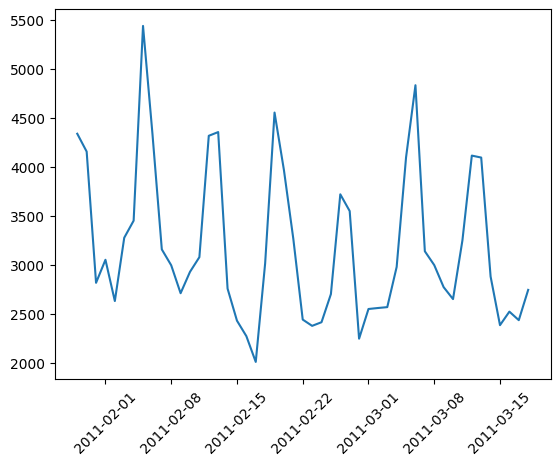

In [97]:
plt.plot(store_level_final['date'][0:49], store_level_final['CA_1'][0:49])
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'Saturday'),
  Text(1, 0, 'Sunday'),
  Text(2, 0, 'Monday'),
  Text(3, 0, 'Tuesday'),
  Text(4, 0, 'Wednesday'),
  Text(5, 0, 'Thursday'),
  Text(6, 0, 'Friday')])

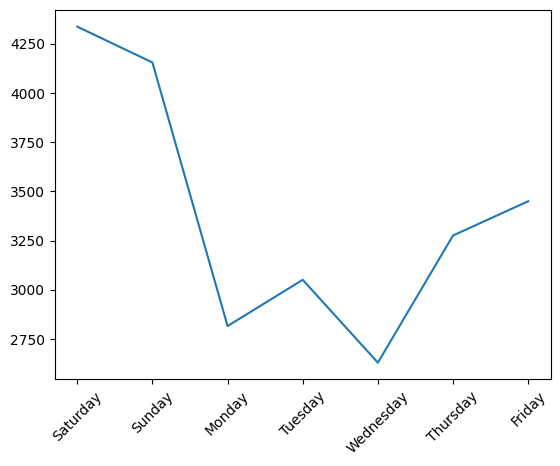

In [98]:
plt.plot(store_level_final['weekday'][0:7], store_level_final['CA_1'][0:7])
plt.xticks(rotation=45)

####There are clear seasonal trends, particularly within the week. Saturday and Sunday see much higher volumes.

##Choosing the right ARIMA model

In [99]:
#We check whether this series is stationary.
#Null Hypo = time series is non-stationary
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):

    #Determing rolling statistics
    rolmean = timeseries.rolling(7).mean()
    rolstd = timeseries.rolling(7).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries[0:100], color='blue',label='Original')
    mean = plt.plot(rolmean[0:100], color='red', label='Rolling Mean')
    std = plt.plot(rolstd[0:100], color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

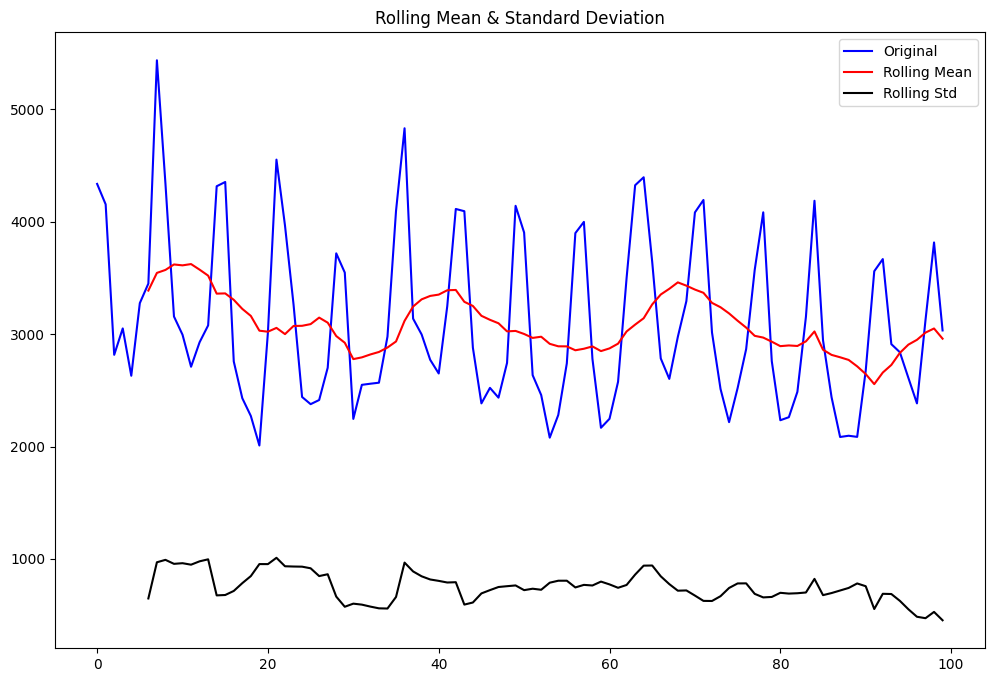

Results of Dickey-Fuller Test:
Test Statistic                 -2.461764
p-value                         0.125057
#Lags Used                     12.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64


In [100]:
test_stationarity(store_level_final['CA_1'][0:100])

Observing the low p value but still higher than 0.05 and negative test statistic but greater than all the critical values at the 1%, 5%, and 10% levels we cannot reject the null hypothesis and conclude that data is stationary
but

We dont need to reject the null hypothesis and it is a good candidate to work with the ARIMA model, as there is peak in weekends so there can be seasonality

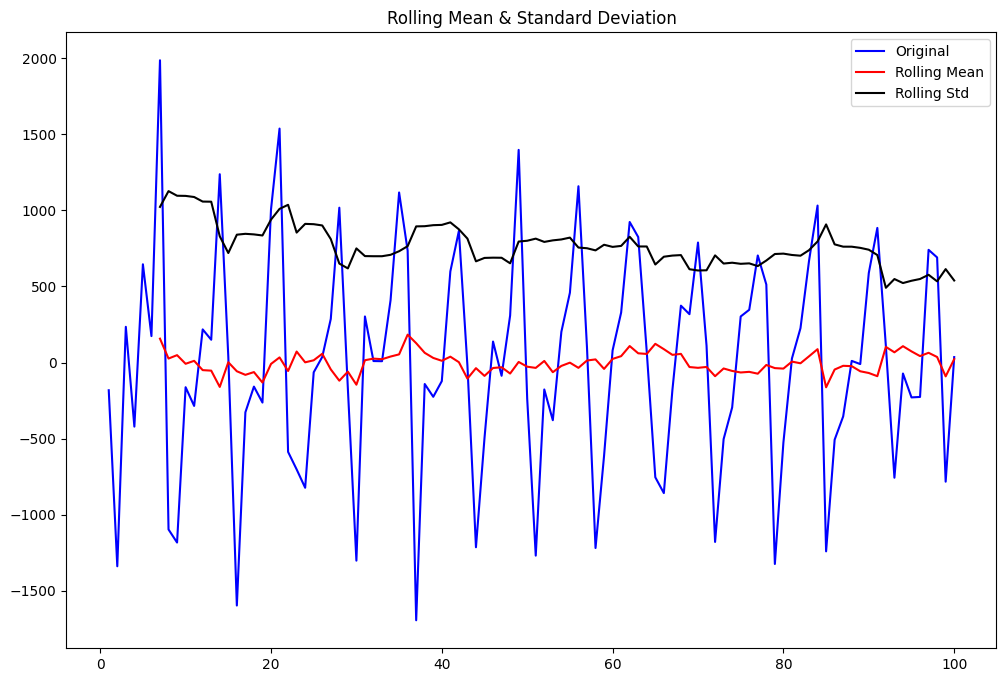

Results of Dickey-Fuller Test:
Test Statistic                  -20.626012
p-value                           0.000000
#Lags Used                       26.000000
Number of Observations Used    1885.000000
Critical Value (1%)              -3.433824
Critical Value (5%)              -2.863075
Critical Value (10%)             -2.567587
dtype: float64


In [101]:
#We check for difference between prior day now
store_level_final['first_difference'] = store_level_final['CA_1'] - store_level_final['CA_1'].shift(1)
test_stationarity(store_level_final['first_difference'].dropna())

###Let us see for Weekly differences¶
####From previous analysis, it is clear that people shop more on the weekend.  if we difference to account for the weekly seasonality

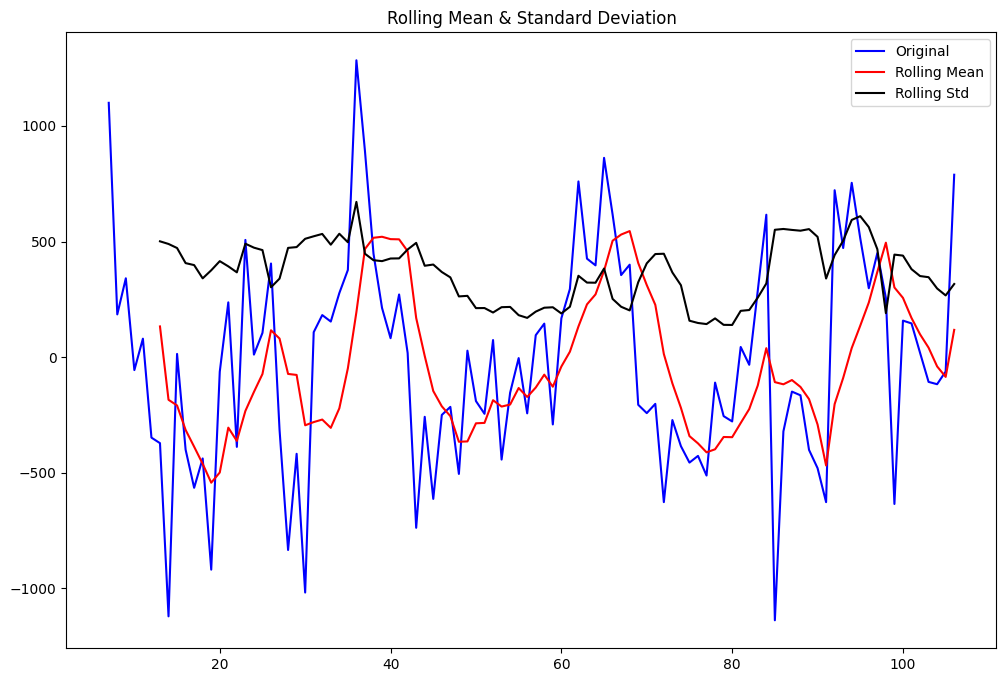

Results of Dickey-Fuller Test:
Test Statistic                  -19.400488
p-value                           0.000000
#Lags Used                       23.000000
Number of Observations Used    1882.000000
Critical Value (1%)              -3.433829
Critical Value (5%)              -2.863077
Critical Value (10%)             -2.567588
dtype: float64


In [102]:
store_level_final['seasonal_difference'] = store_level_final['CA_1'] - store_level_final['CA_1'].shift(7)
test_stationarity(store_level_final['seasonal_difference'].dropna())

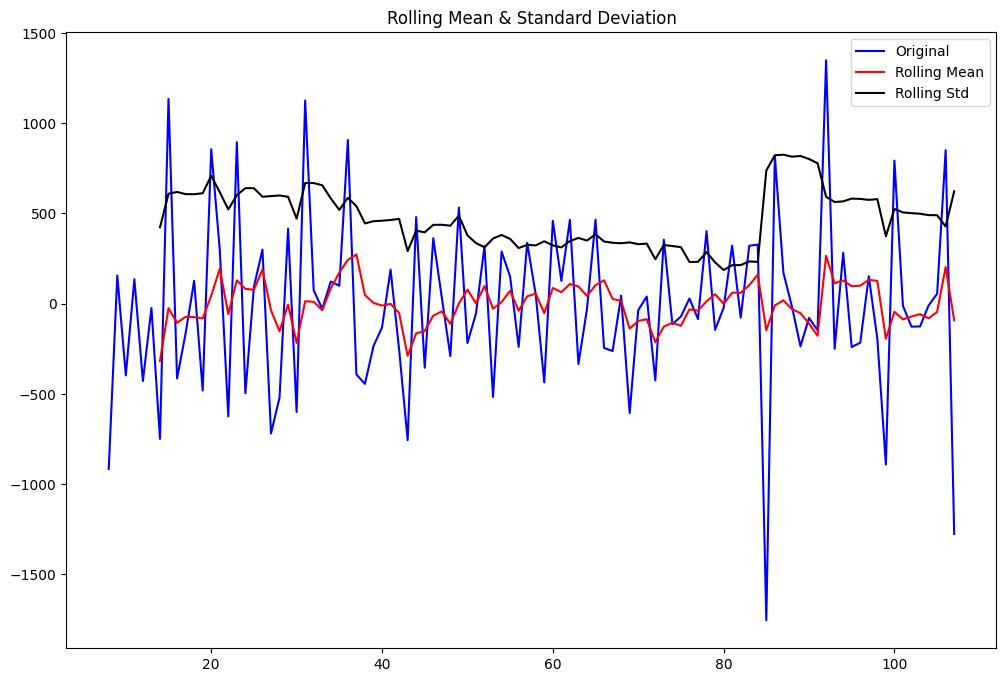

Results of Dickey-Fuller Test:
Test Statistic                  -19.739548
p-value                           0.000000
#Lags Used                       25.000000
Number of Observations Used    1879.000000
Critical Value (1%)              -3.433835
Critical Value (5%)              -2.863079
Critical Value (10%)             -2.567590
dtype: float64


In [103]:
#Combining both
#  store_level_final['CA_1'].shift(8) for overlapp
store_level_final['seasonal_first_difference'] = store_level_final['CA_1'] - store_level_final['CA_1'].shift(1) - store_level_final['CA_1'].shift(7) + store_level_final['CA_1'].shift(8)
test_stationarity(store_level_final['seasonal_first_difference'].dropna())

In [104]:
from pandas.plotting import autocorrelation_plot

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

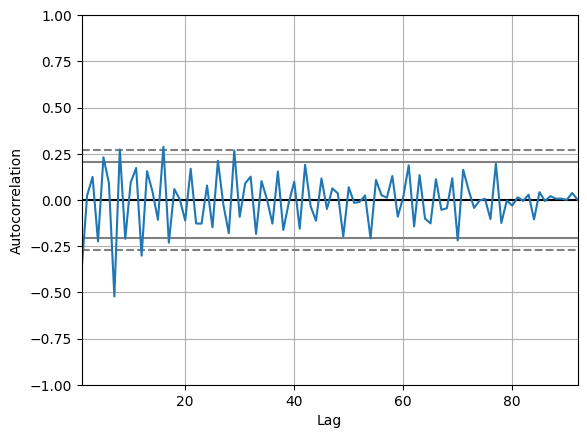

In [105]:
autocorrelation_plot(store_level_final['seasonal_first_difference'][8:100])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

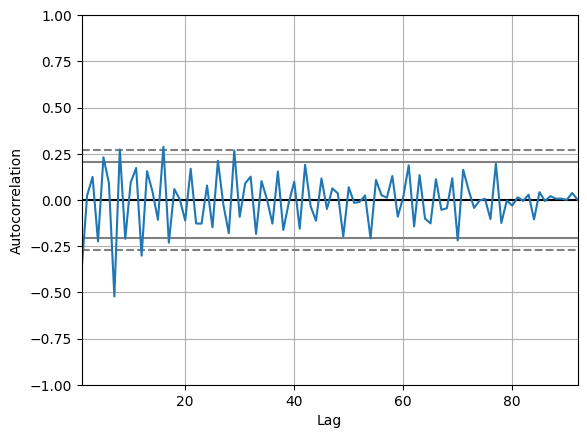

In [106]:
autocorrelation_plot(store_level_final['seasonal_first_difference'][8:100])

In [107]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

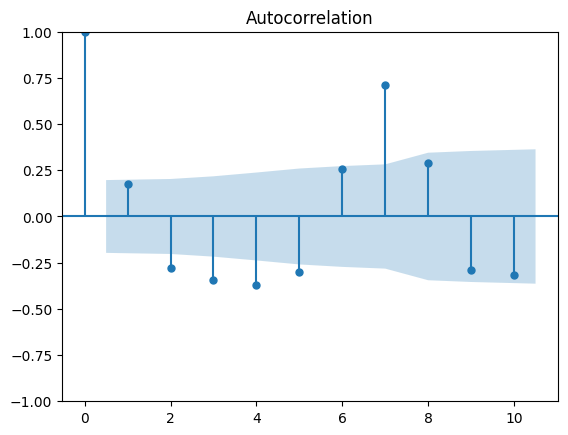

In [108]:
plot_acf(store_level_final['first_difference'][0:100].dropna(), lags=10);

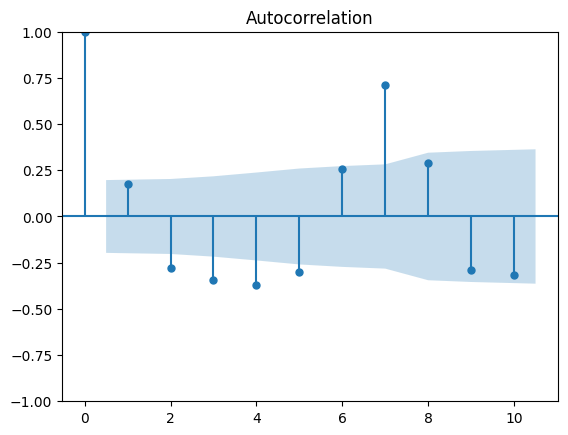

In [109]:
plot_acf(store_level_final['first_difference'][0:100].dropna(), lags=10);

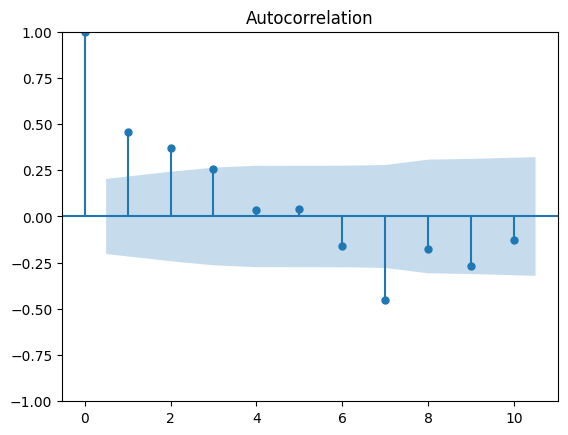

In [110]:
plot_acf(store_level_final['seasonal_difference'][0:100].dropna(), lags=10);

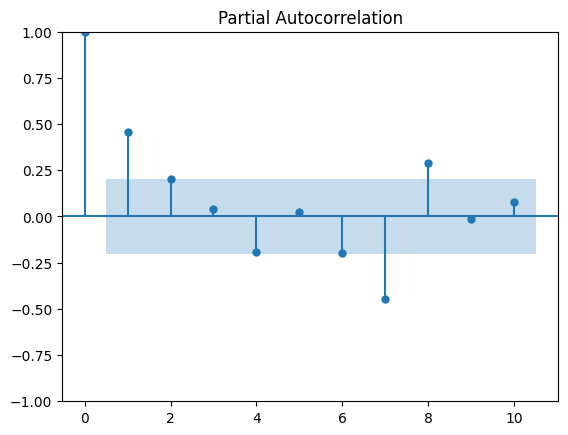

In [111]:
plot_pacf(store_level_final['seasonal_difference'][0:100].dropna(), lags=10);

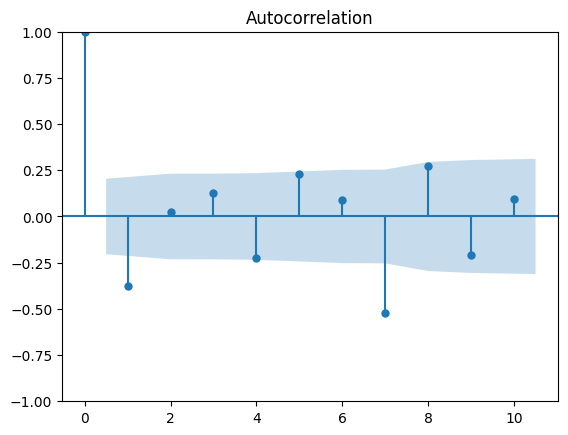

In [112]:
plot_acf(store_level_final['seasonal_first_difference'][0:100].dropna(), lags=10);

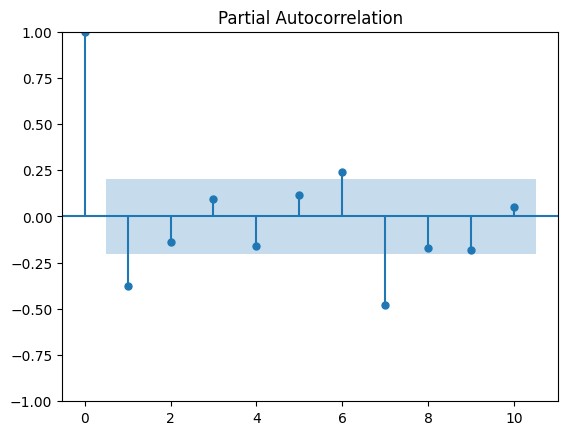

In [113]:
plot_pacf(store_level_final['seasonal_first_difference'][0:100].dropna(), lags=10);

In [114]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(store_level_final['first_difference'].dropna())

Based on the spikes at 1 for all the graphs above, we use a ARIMA model of (0, 1, 1)(1, 1, 1)

##Now we implement the model!

In [115]:
train = np.asarray(store_level_final['first_difference'].dropna()[0:1880].astype(float))
test = np.asarray(store_level_final['first_difference'].dropna()[1880:-1].astype(float))

In [116]:
print(store_level_final['first_difference'].dropna().dropna()[0:18])
print(store_level_final['first_difference'][18:-1])

1      -182
2     -1339
3       235
4      -421
5       646
6       174
7      1987
8     -1097
9     -1183
10     -162
11     -285
12      218
13      150
14     1238
15       38
16    -1597
17     -327
18     -158
Name: first_difference, dtype: object
18      -158
19      -263
20      1006
21      1538
22      -587
        ... 
1907    -552
1908     -71
1909     -13
1910     678
1911    1190
Name: first_difference, Length: 1894, dtype: object


In [117]:
import statsmodels.api as sm

mlflow.start_run(run_name="SARIMAX-1")
mlflow.log_params({"order": "(0,1,1)", "seasonal_order": "(1,1,1,7)"})
mod = sm.tsa.statespace.SARIMAX(train, order=(0,1,1), seasonal_order=(1,1,1,7))
results=mod.fit()
print(results.summary())

/opt/anaconda3/envs/walmart/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1880
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -14373.730
Date:                           Sat, 28 Feb 2026   AIC                          28755.461
Time:                                   13:45:43   BIC                          28777.600
Sample:                                        0   HQIC                         28763.617
                                          - 1880                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      0.095    -10.544      0.000      -1.186      -0.814
ar.S.L7        0.1529      0.019      8.031

In [118]:
len(train), len(test)

(1880, 31)

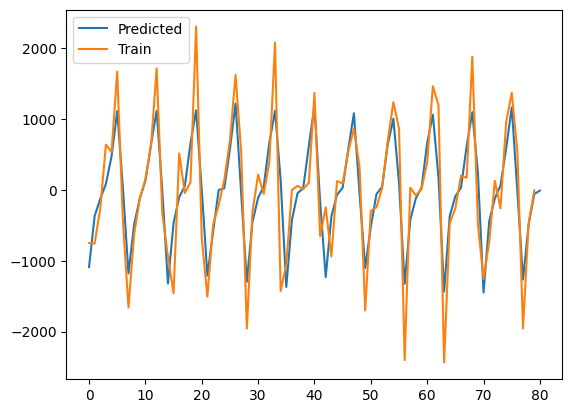

In [119]:
#Predicting on train data
plt.plot(results.predict(start = 1800, end = 1880), label = 'Predicted')
plt.plot(train[1800:1880], label = 'Train')
plt.legend(loc = "upper left")

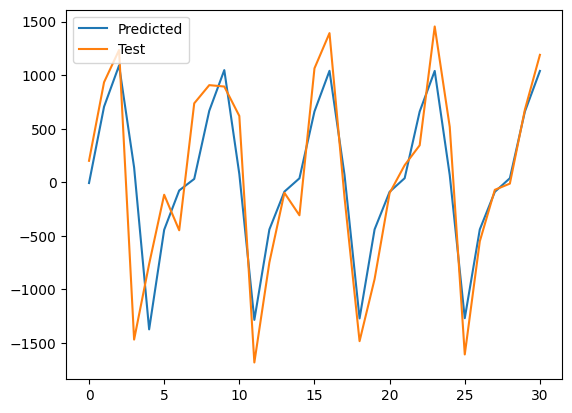

In [120]:
# Predicting on test data
plt.plot(results.predict(start = len(train), end = len(train)+len(test)-1), label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')

In [121]:
from sklearn.metrics import mean_squared_error
import math
mse = mean_squared_error(test, results.predict(start=1880, end=len(train)+len(test)-1))
rmse_sarimax1 = math.sqrt(mse)
mlflow.log_metric("rmse", rmse_sarimax1)
with tempfile.NamedTemporaryFile(suffix=".pkl", delete=False) as f:
    pickle.dump(results, f)
    path = f.name
mlflow.log_artifact(path, artifact_path="model")
os.unlink(path)
mlflow.end_run()
rmse_sarimax1

432.5968098878573

Taking Small data to train (Just trying)

In [122]:
train2 = np.asarray(store_level_final['first_difference'][1500:1880].astype(float))
test2 = np.asarray(store_level_final['first_difference'][1880:-1].astype(float))

In [123]:
import statsmodels.api as sm

mlflow.start_run(run_name="SARIMAX-2")
mlflow.log_params({"order": "(0,1,1)", "seasonal_order": "(1,1,1,7)"})
mod2 = sm.tsa.statespace.SARIMAX(train2, order=(0,1,1), seasonal_order=(1,1,1,7))
results2=mod2.fit()
print(results2.summary())

/opt/anaconda3/envs/walmart/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                  380
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -2879.207
Date:                           Sat, 28 Feb 2026   AIC                           5766.414
Time:                                   13:45:43   BIC                           5782.089
Sample:                                        0   HQIC                          5772.639
                                           - 380                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      0.029    -34.329      0.000      -1.057      -0.943
ar.S.L7        0.0932      0.064      1.445

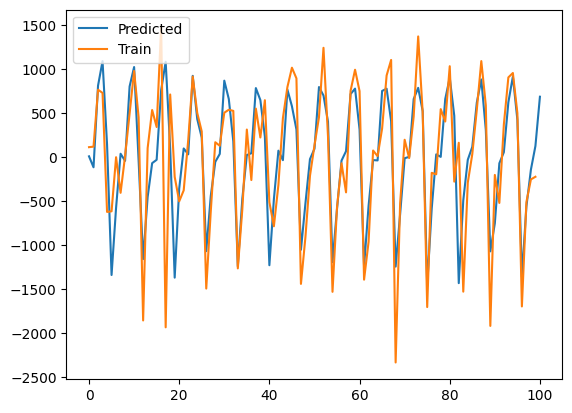

In [124]:
plt.plot(results2.predict(start = 100, end = 200), label = 'Predicted')
plt.plot(train2[100:200], label = 'Train')
plt.legend(loc = "upper left")

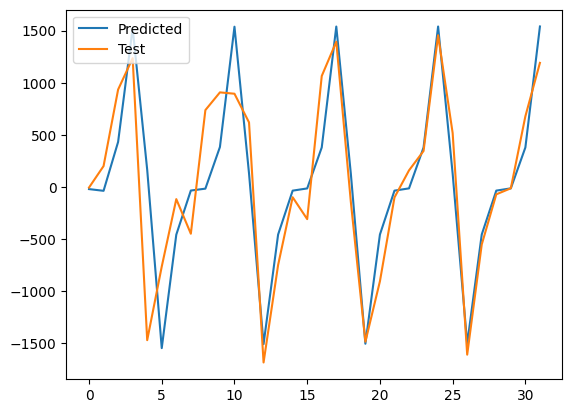

In [125]:
plt.plot(results2.predict(start = 380, end = 411), label = 'Predicted')
plt.plot(test2, label = 'Test')
plt.legend(loc = "upper left")

In [126]:
mse2 = mean_squared_error(test2, results2.predict(start=380, end=411))
rmse_sarimax2 = math.sqrt(mse2)
mlflow.log_metric("rmse", rmse_sarimax2)
with tempfile.NamedTemporaryFile(suffix=".pkl", delete=False) as f:
    pickle.dump(results2, f)
    path = f.name
mlflow.log_artifact(path, artifact_path="model")
os.unlink(path)
mlflow.end_run()
rmse_sarimax2

462.9547930814528

In [127]:
store_level

,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,d_10,...,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913,d
store_id,,,,,,,,,,,,,,,,,,,,,
CA_1,4337,4155,2816,3051,2630,3276,3450,5437,4340,3157,...,5437,5954,4345,3793,3722,3709,4387,5577,6113,CA_1
CA_2,3494,3046,2121,2324,1942,2288,2629,3729,2957,2218,...,5352,5760,3830,3631,3691,3303,4457,5884,6082,CA_2
CA_3,4739,4827,3785,4232,3817,4369,4703,5456,5581,4912,...,6936,8271,6068,5683,5235,5018,5623,7419,7721,CA_3
CA_4,1625,1777,1386,1440,1536,1389,1469,1988,1818,1535,...,2839,3047,2809,2677,2500,2458,2628,2954,3271,CA_4
TX_1,2556,2687,1822,2258,1694,2734,1691,2820,2887,2174,...,3724,4192,3410,3257,2901,2776,3022,3700,4033,TX_1
TX_2,3852,3937,2731,2954,2492,3439,2588,3772,3657,2932,...,4475,4998,3311,3727,3384,3446,3902,4483,4292,TX_2
TX_3,3030,3006,2225,2169,1726,2833,1947,2848,2832,2213,...,4261,4519,3147,3938,3315,3380,3691,4083,3957,TX_3
WI_1,2704,2194,1562,1251,2,2049,2815,3248,1674,1355,...,4862,4812,3236,3069,3242,3324,3991,4772,4874,WI_1
WI_2,2256,1922,2018,2522,1175,2244,2232,2643,2140,1836,...,5579,5566,4347,4464,4194,4393,4988,5404,5127,WI_2


Let's use autoarima to find the best model

In [128]:
!pip install pmdarima --quiet
import pmdarima as pm

In [129]:
mlflow.start_run(run_name="SARIMA-auto_arima")
mlflow.log_params({"m": 7, "seasonal": True, "D": 1})
SARIMA_model = pm.auto_arima(train,
                             start_p=1,
                             start_q=1,
                             test='adf',  # Augmented Dickey-Fuller test
                             m=7,  # Weekly seasonality
                             start_P=0,
                             seasonal=True,  # Fit a seasonal model
                             d=None,  # Automatically determine the order of differencing
                             D=1,  # Seasonal differencing order
                             trace=True,  # No output during the search process
                             error_action='ignore',  # Ignore orders that do not work
                             suppress_warnings=True,  # Suppress warnings
                             stepwise=False)

 ARIMA(0,0,0)(0,1,0)[7] intercept   : AIC=29754.574, Time=0.03 sec
 ARIMA(0,0,0)(0,1,1)[7] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(0,1,2)[7] intercept   : AIC=inf, Time=2.00 sec
 ARIMA(0,0,0)(1,1,0)[7] intercept   : AIC=29218.640, Time=0.46 sec
 ARIMA(0,0,0)(1,1,1)[7] intercept   : AIC=inf, Time=1.58 sec
 ARIMA(0,0,0)(1,1,2)[7] intercept   : AIC=inf, Time=3.99 sec
 ARIMA(0,0,0)(2,1,0)[7] intercept   : AIC=29057.360, Time=1.00 sec
 ARIMA(0,0,0)(2,1,1)[7] intercept   : AIC=inf, Time=3.20 sec
 ARIMA(0,0,0)(2,1,2)[7] intercept   : AIC=inf, Time=4.70 sec
 ARIMA(0,0,1)(0,1,0)[7] intercept   : AIC=29318.077, Time=0.13 sec
 ARIMA(0,0,1)(0,1,1)[7] intercept   : AIC=inf, Time=0.97 sec
 ARIMA(0,0,1)(0,1,2)[7] intercept   : AIC=inf, Time=2.97 sec
 ARIMA(0,0,1)(1,1,0)[7] intercept   : AIC=28785.621, Time=0.68 sec
 ARIMA(0,0,1)(1,1,1)[7] intercept   : AIC=inf, Time=1.64 sec
 ARIMA(0,0,1)(1,1,2)[7] intercept   : AIC=inf, Time=4.78 sec
 ARIMA(0,0,1)(2,1,0)[7] intercept   : AIC=28636.646, Ti

In [130]:
train_pred = SARIMA_model.predict_in_sample(start=1, end=-1)
test_pred, confint = SARIMA_model.predict(n_periods=len(test), return_conf_int=True)

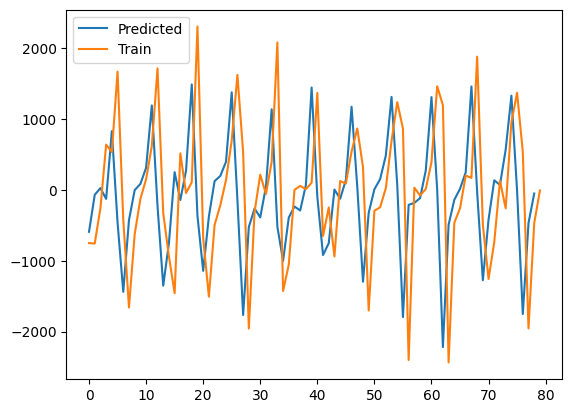

In [131]:
#Predicting on train data
plt.plot(train_pred[1800:1880], label = 'Predicted')
plt.plot(train[1800:1880], label = 'Train')
plt.legend(loc = "upper left")

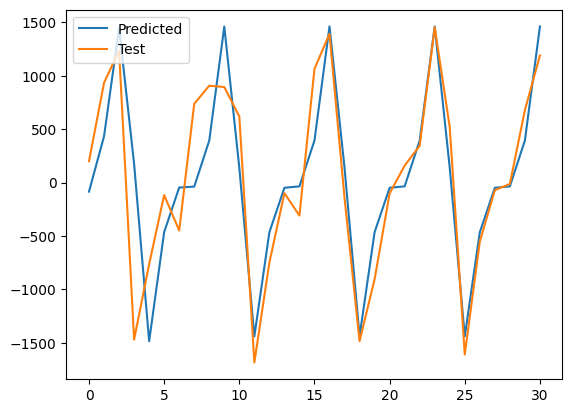

In [132]:
# Predicting on test data
plt.plot(test_pred, label = 'Predicted')
plt.plot(test, label = 'Test')
plt.legend(loc = 'upper left')

In [133]:
rmse_auto_arima = math.sqrt(mean_squared_error(test_pred, test))
mlflow.log_metric("rmse", rmse_auto_arima)
with tempfile.NamedTemporaryFile(suffix=".pkl", delete=False) as f:
    pickle.dump(SARIMA_model, f)
    path = f.name
mlflow.log_artifact(path, artifact_path="model")
os.unlink(path)
mlflow.end_run()
rmse_auto_arima

462.32236212762723

##Now let's try Category wise projections as there are only 3 categories will predict for each (For Practice)
(before we had store wise)



In [134]:
numerical_columns = sales_train_validation.select_dtypes(include=['number'])
category_sales = numerical_columns.groupby(sales_train_validation['cat_id']).sum()
category_salest = category_sales.transpose()
category_salest['d'] = category_salest.index
category_salest.head()

cat_id,FOODS,HOBBIES,HOUSEHOLD,d
d_1,23178,3764,5689,d_1
d_2,22758,3357,5634,d_2
d_3,17174,2682,3927,d_3
d_4,18878,2669,3865,d_4
d_5,14603,1814,2729,d_5


In [135]:
#Merge this with the calendar data set to look at trends
category_level_final = category_salest.merge(calendar, on='d')
category_level_final['date'] = category_level_final['date'].apply(lambda t: datetime.strptime(t, '%Y-%m-%d'))
category_level_final

,FOODS,HOBBIES,HOUSEHOLD,d,date,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,23178,3764,5689,d_1,2011-01-29,11101,Saturday,1,1,2011,NaN,NaN,NaN,NaN,0,0,0
1,22758,3357,5634,d_2,2011-01-30,11101,Sunday,2,1,2011,NaN,NaN,NaN,NaN,0,0,0
2,17174,2682,3927,d_3,2011-01-31,11101,Monday,3,1,2011,NaN,NaN,NaN,NaN,0,0,0
3,18878,2669,3865,d_4,2011-02-01,11101,Tuesday,4,2,2011,NaN,NaN,NaN,NaN,1,1,0
4,14603,1814,2729,d_5,2011-02-02,11101,Wednesday,5,2,2011,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908,23632,3472,8239,d_1909,2016-04-20,11612,Wednesday,5,4,2016,NaN,NaN,NaN,NaN,0,0,0
1909,23317,3353,8363,d_1910,2016-04-21,11612,Thursday,6,4,2016,NaN,NaN,NaN,NaN,0,0,0
1910,26704,4085,9728,d_1911,2016-04-22,11612,Friday,7,4,2016,NaN,NaN,NaN,NaN,0,0,0
1911,31927,4787,12248,d_1912,2016-04-23,11613,Saturday,1,4,2016,NaN,NaN,NaN,NaN,0,0,0


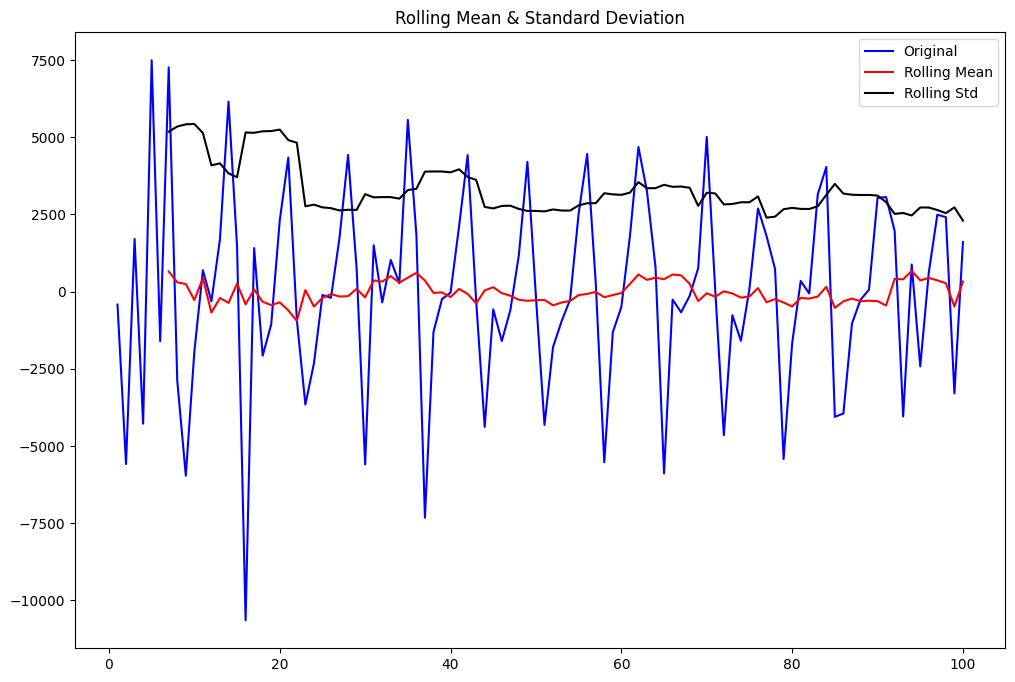

Results of Dickey-Fuller Test:
Test Statistic                  -24.380260
p-value                           0.000000
#Lags Used                       26.000000
Number of Observations Used    1885.000000
Critical Value (1%)              -3.433824
Critical Value (5%)              -2.863075
Critical Value (10%)             -2.567587
dtype: float64


In [136]:
category_level_final['first_difference_food'] = category_level_final['FOODS'] - category_level_final['FOODS'].shift(1)
test_stationarity(category_level_final['first_difference_food'].dropna())

Text(0.5, 1.0, 'Food: SARIMA Model Prediction vs. Test with RMSE = 4726')

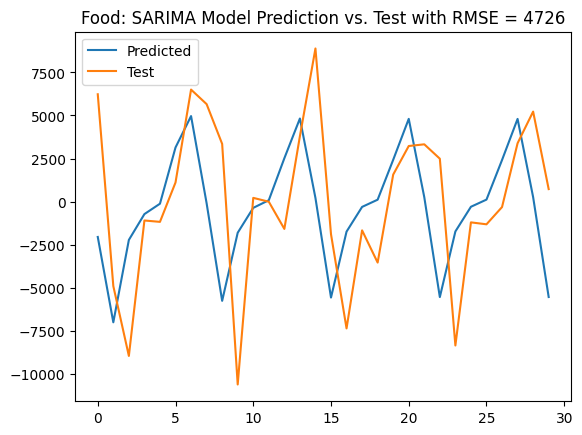

In [137]:
train_food = np.asarray(category_level_final['first_difference_food'].dropna()[0:1883].astype(float))
test_food = np.asarray(category_level_final['first_difference_food'][1883:].astype(float))
n_test = len(test_food)

# Fit SARIMAX model
mod_food = sm.tsa.statespace.SARIMAX(train_food, order=(1, 0, 1), seasonal_order=(1, 1, 1, 7)) # Chosen by auto-arima
results_food = mod_food.fit()

# Predict
start_pred = len(train_food)  # 1883
end_pred = start_pred + n_test - 1  # 1883 + n_test - 1

# Plotting
plt.plot(results_food.predict(start=start_pred, end=end_pred), label='Predicted')
plt.plot(test_food, label='Test')
plt.legend(loc='upper left')

# Calculate RMSE
predicted_values = results_food.predict(start=start_pred, end=end_pred)
rmse = math.sqrt(mean_squared_error(test_food, predicted_values))
plt.title("Food: SARIMA Model Prediction vs. Test with RMSE = " + "{:.0f}".format(rmse))

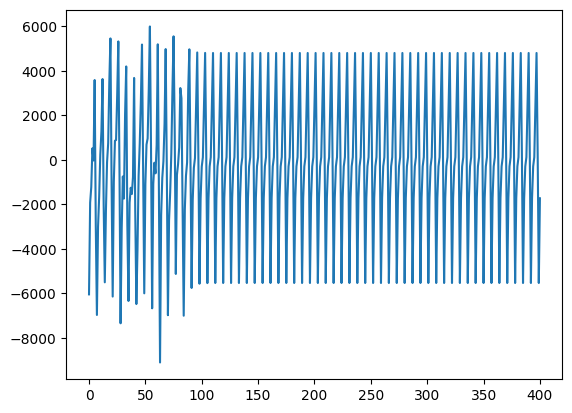

In [138]:
plt.plot(results_food.predict(start = 1800, end = 2200), label = 'Predicted') # a prediction above the test samples ie till 2200

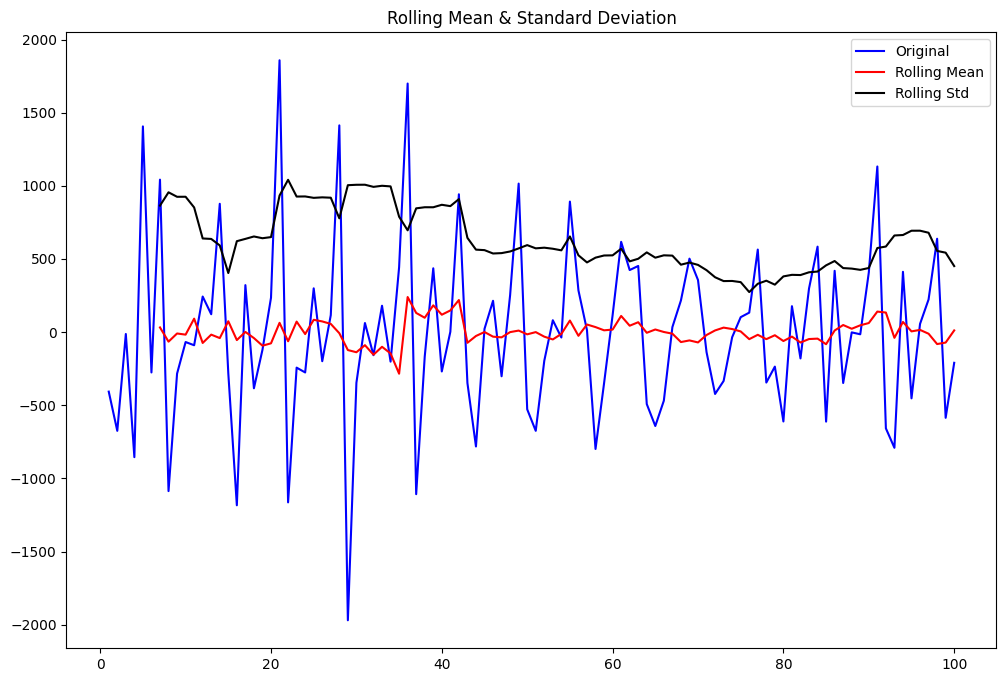

Results of Dickey-Fuller Test:
Test Statistic                -1.441951e+01
p-value                        7.955431e-27
#Lags Used                     2.600000e+01
Number of Observations Used    1.885000e+03
Critical Value (1%)           -3.433824e+00
Critical Value (5%)           -2.863075e+00
Critical Value (10%)          -2.567587e+00
dtype: float64


In [139]:
category_level_final['first_difference_hobbies'] = category_level_final['HOBBIES'] - category_level_final['HOBBIES'].shift(1)
test_stationarity(category_level_final['first_difference_hobbies'].dropna())

Text(0.5, 1.0, 'hobbies: SARIMA Model Prediction vs. Test with RMSE = 617')

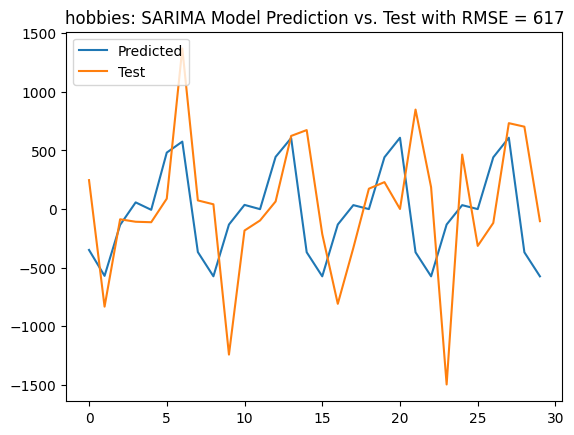

In [140]:
train_hobbies = np.asarray(category_level_final['first_difference_hobbies'].dropna()[0:1883].astype(float))
test_hobbies = np.asarray(category_level_final['first_difference_hobbies'][1883:].astype(float))
n_test = len(test_hobbies)

# Fit SARIMAX model
mod_hobbies = sm.tsa.statespace.SARIMAX(train_hobbies, order=(1, 0, 1), seasonal_order=(1, 1, 1, 7)) # Chosen by auto-arima
results_hobbies = mod_hobbies.fit()

# Predict
start_pred = len(train_hobbies)  # 1883
end_pred = start_pred + n_test - 1  # 1883 + n_test - 1

# Plotting
plt.plot(results_hobbies.predict(start=start_pred, end=end_pred), label='Predicted')
plt.plot(test_hobbies, label='Test')
plt.legend(loc='upper left')

# Calculate RMSE
predicted_values = results_hobbies.predict(start=start_pred, end=end_pred)
rmse = math.sqrt(mean_squared_error(test_hobbies, predicted_values))
plt.title("hobbies: SARIMA Model Prediction vs. Test with RMSE = " + "{:.0f}".format(rmse))

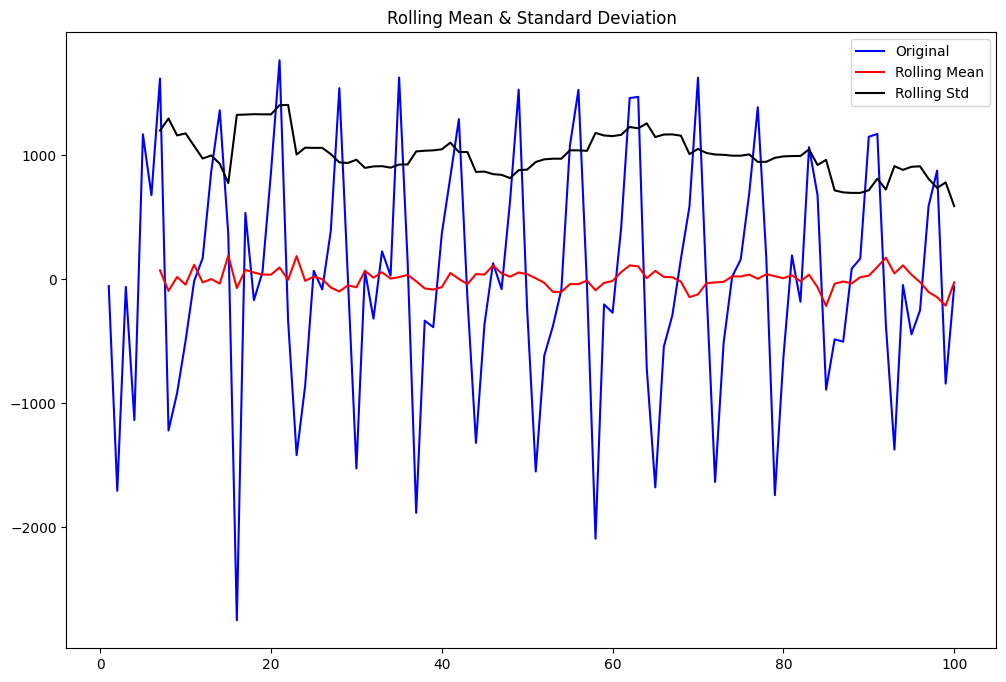

Results of Dickey-Fuller Test:
Test Statistic                -1.354790e+01
p-value                        2.441267e-25
#Lags Used                     2.600000e+01
Number of Observations Used    1.885000e+03
Critical Value (1%)           -3.433824e+00
Critical Value (5%)           -2.863075e+00
Critical Value (10%)          -2.567587e+00
dtype: float64


In [141]:
category_level_final['first_difference_household'] = category_level_final['HOUSEHOLD'] - category_level_final['HOUSEHOLD'].shift(1)
test_stationarity(category_level_final['first_difference_household'].dropna())

/opt/anaconda3/envs/walmart/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Text(0.5, 1.0, 'household: SARIMA Model Prediction vs. Test with RMSE = 801')

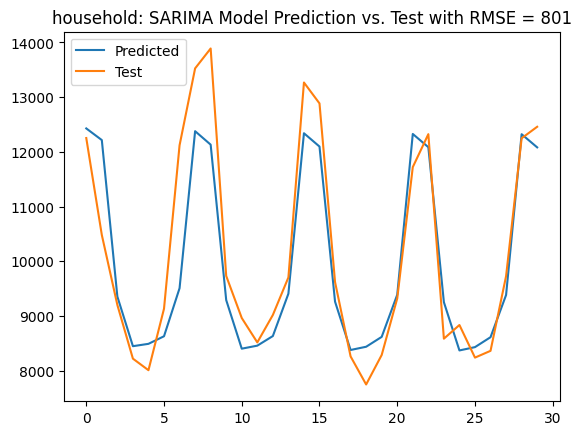

In [142]:
train_household = np.asarray(category_level_final['HOUSEHOLD'][0:1883].astype(float))
test_household = np.asarray(category_level_final['HOUSEHOLD'][1883:].astype(float))
n_test = len(test_household)

# Fit SARIMAX model
mod_household = sm.tsa.statespace.SARIMAX(train_household, order=(1, 0, 1), seasonal_order=(1, 1, 1, 7)) # Chosen by auto-arima
results_household = mod_household.fit()

# Predict
start_pred = len(train_household)  # 1883
end_pred = start_pred + n_test - 1  # 1883 + n_test - 1

# Plotting
plt.plot(results_household.predict(start=start_pred, end=end_pred), label='Predicted')
plt.plot(test_household, label='Test')
plt.legend(loc='upper left')

# Calculate RMSE
predicted_values = results_household.predict(start=start_pred, end=end_pred)
rmse = math.sqrt(mean_squared_error(test_household, predicted_values))
plt.title("household: SARIMA Model Prediction vs. Test with RMSE = " + "{:.0f}".format(rmse))

##Exponential Smoothening

Let's go back with stores prediction (only for first store)

In [143]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [144]:
train = np.asarray(store_level_final['first_difference'].dropna()[0:1880].astype(float))
test = np.asarray(store_level_final['first_difference'].dropna()[1880:-1].astype(float))

In [145]:
len(train), len(test)

(1880, 31)

In [146]:
mlflow.start_run(run_name="Exponential Smoothing")
mlflow.log_params({"trend": "add", "seasonal": "add", "seasonal_periods": 7})
model_hw = ExponentialSmoothing(train, trend='add', seasonal='add', seasonal_periods=7)
fit_hw = model_hw.fit()
print(fit_hw.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                 1880
Model:             ExponentialSmoothing   SSE                      506463673.658
Optimized:                         True   AIC                          23529.400
Trend:                         Additive   BIC                          23590.329
Seasonal:                      Additive   AICC                         23529.595
Seasonal Periods:                     7   Date:                 Sat, 28 Feb 2026
Box-Cox:                          False   Time:                         13:49:49
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level              1.4901e-08                alpha                 True
smoothing_trend          

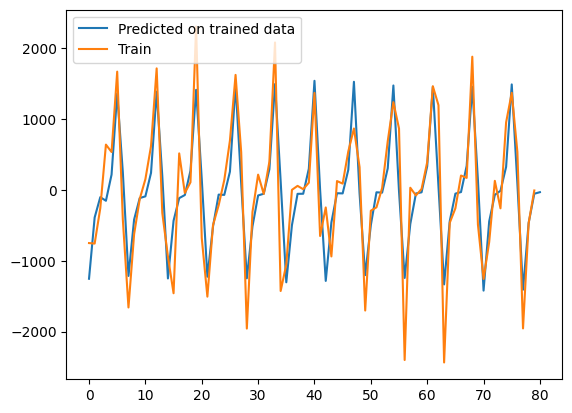

In [147]:
plt.plot(fit_hw.predict(start = 1800, end = 1880), label = 'Predicted on trained data')
plt.plot(train[1800:1880], label = 'Train')
plt.legend(loc = "upper left")

In [148]:
1880+len(test)-1

1910

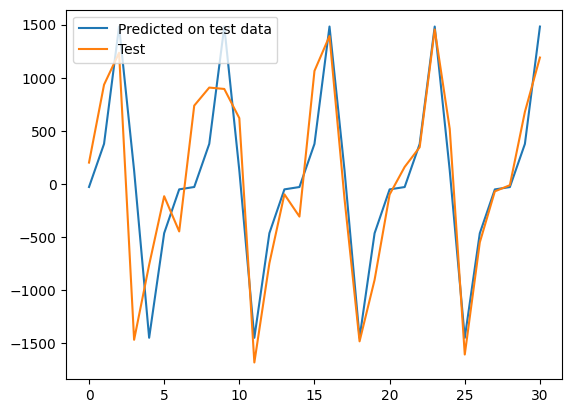

In [149]:
plt.plot(fit_hw.predict(start = 1880, end = 1910), label = 'Predicted on test data')
plt.plot(test, label = 'Test')
plt.legend(loc = "upper left")

In [150]:
rmse_hw = math.sqrt(mean_squared_error(fit_hw.predict(start=1880, end=1910), test))
mlflow.log_metric("rmse", rmse_hw)
with tempfile.NamedTemporaryFile(suffix=".pkl", delete=False) as f:
    pickle.dump(fit_hw, f)
    path = f.name
mlflow.log_artifact(path, artifact_path="model")
os.unlink(path)
mlflow.end_run()
rmse_hw

459.56225771549555

##Let's do for category (for all three category) for Practice

Text(0.5, 1.0, 'Food: Exponential Smoothing Model Prediction vs. Test with RMSE = 4691')

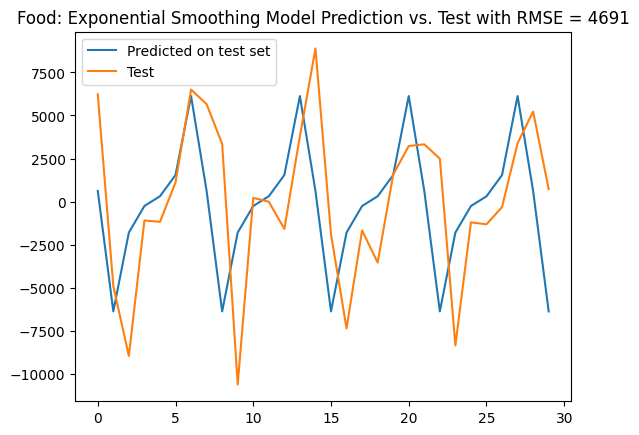

In [151]:
train_food = np.asarray(category_level_final['first_difference_food'].dropna()[0:1883].astype(float))
test_food = np.asarray(category_level_final['first_difference_food'][1883:].astype(float))
n_test = len(test_food)

# Fit ExponentialSmoothing model
model_hw_food = ExponentialSmoothing(train_food, trend='add', seasonal='add', seasonal_periods=7)
fit_hw_food = model_hw_food.fit()

# Predict
start_pred = len(train_food)  # 1883
end_pred = start_pred + n_test - 1  # 1883 + n_test - 1

# Plotting
plt.plot(fit_hw_food.predict(start=start_pred, end=end_pred), label='Predicted on test set')
plt.plot(test_food, label='Test')
plt.legend(loc='upper left')

# Calculate RMSE
predicted_values = fit_hw_food.predict(start=start_pred, end=end_pred)
rmse = math.sqrt(mean_squared_error(test_food, predicted_values))
plt.title("Food: Exponential Smoothing Model Prediction vs. Test with RMSE = " + "{:.0f}".format(rmse))

Text(0.5, 1.0, 'Hobbies: Exponential Smoothing Model Prediction vs. Test with RMSE = 655')

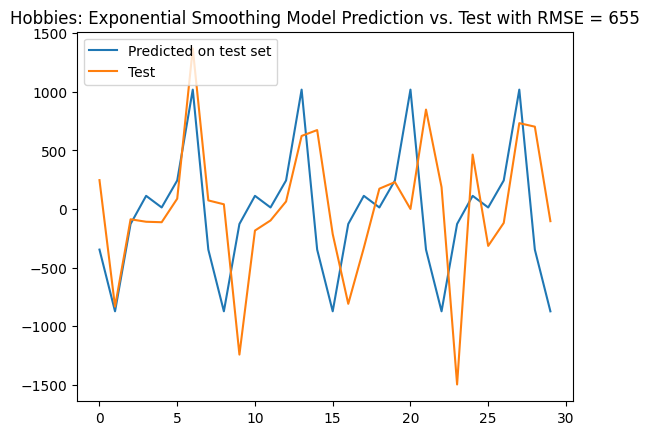

In [152]:
train_hobbies = np.asarray(category_level_final['first_difference_hobbies'].dropna()[0:1883].astype(float))
test_hobbies = np.asarray(category_level_final['first_difference_hobbies'][1883:].astype(float))
n_test = len(test_hobbies)

# Fit ExponentialSmoothing model
model_hw_hobbies = ExponentialSmoothing(train_hobbies, trend='add', seasonal='add', seasonal_periods=7)
fit_hw_hobbies = model_hw_hobbies.fit()

# Predict
start_pred = len(train_hobbies)  # 1883
end_pred = start_pred + n_test - 1  # 1883 + n_test - 1

# Plotting
plt.plot(fit_hw_hobbies.predict(start=start_pred, end=end_pred), label='Predicted on test set')
plt.plot(test_hobbies, label='Test')
plt.legend(loc='upper left')

# Calculate RMSE
predicted_values = fit_hw_hobbies.predict(start=start_pred, end=end_pred)
rmse = math.sqrt(mean_squared_error(test_hobbies, predicted_values))
plt.title("Hobbies: Exponential Smoothing Model Prediction vs. Test with RMSE = " + "{:.0f}".format(rmse))

Text(0.5, 1.0, 'Household: Exponential Smoothing Model Prediction vs. Test with RMSE = 1944')

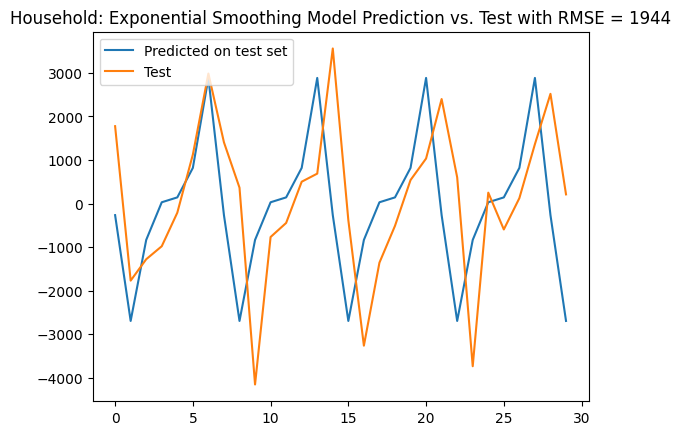

In [153]:
train_household = np.asarray(category_level_final['first_difference_household'].dropna()[0:1883].astype(float))
test_household = np.asarray(category_level_final['first_difference_household'][1883:].astype(float))
n_test = len(test_hobbies)

# Fit ExponentialSmoothing model
model_hw_household = ExponentialSmoothing(train_household, trend='add', seasonal='add', seasonal_periods=7)
fit_hw_household = model_hw_household.fit()

# Predict
start_pred = len(train_household)  # 1883
end_pred = start_pred + n_test - 1  # 1883 + n_test - 1

# Plotting
plt.plot(fit_hw_household.predict(start=start_pred, end=end_pred), label='Predicted on test set')
plt.plot(test_household, label='Test')
plt.legend(loc='upper left')

# Calculate RMSE
predicted_values = fit_hw_household.predict(start=start_pred, end=end_pred)
rmse = math.sqrt(mean_squared_error(test_household, predicted_values))
plt.title("Household: Exponential Smoothing Model Prediction vs. Test with RMSE = " + "{:.0f}".format(rmse))

I calculated MAE for sarima model by mistake so calculating RMSE as other models are in that metric

In [154]:
import math

In [155]:
rmse_sarima_wd = math.sqrt(181901.68869775155)
rmse_sarima_wd

426.49934196637577

In [156]:
rmse_sarima_ad = math.sqrt(215249.8234171326)
rmse_sarima_ad

463.95023808284935

#Store Wise Prediction Results (For store only CA1) (RMSE) (Without Differencing Columns)

SARIMA: 426.49934196637577

Exponential Smoothing: 400.3475752176327

#Store Wise Prediction Results (For store only CA1) (RMSE) (After Differencing Columns)

SARIMA: 463.95023808284935

Exponential Smoothing: 455.8609428454517

Lost the code where i trained on data without differencing as i made changes to that code for predicting on differnced data but i recoreded the accuracy